In [70]:
import matplotlib.pyplot as plt
from highlight_text import HighlightText, ax_text, fig_text
# or
import highlight_text # then use highlight_text.ax_text or highlight_text.fig_text
import matplotlib.colors as colors
import numpy as np

import pickle

In [71]:
with open("subplan-dropout-attrs.pkl", "rb") as f:
    dropoutdata = pickle.load(f)

with open("subplan-default-attrs.pkl", "rb") as f:
    defaultdata = pickle.load(f)

In [72]:
def find_index(allsqls, tables):
    for i,sql in enumerate(allsqls):
        sql = sql.lower()
        num_tabs = len(sql.split("as"))-2
        
        if num_tabs != len(tables):
            continue
        
        #print(sql)
        allinsql = True
        for t in tables:
            if "as " + t not in sql:
                allinsql = False
                break
        if allinsql:
            return i
        
    return None

def get_col_idx(xlabels, col):
    curidx = None
    for xi, xlabel in enumerate(xlabels):
        if col == xlabel:
            curidx = xi
            break
    return curidx

def color_subsql(subsql, xlabels, scores):
    
    fstrs = []
    tstrs = []
    attrvals = []
    
    tables = subsql.split("WHERE")[0]
    tables = tables[tables.find("FROM")+5:]
    tables = tables.split(",")

    for t in tables:
        tab = t.split("AS")[0]
        alias = t.split("AS")[1]
        tab = tab.replace(" ", "")
        alias = alias.replace(" ", "")
        
        curidx = None
        for xi, xlabel in enumerate(xlabels):
            if tab == xlabel:
                curidx = xi
        assert curidx is not None
        
        tab = "{} AS {}".format(tab, alias)
        tstrs.append("<" + tab + ">")
        attrvals.append(scores[curidx])
    
    filters = subsql.split("WHERE")[1]
    filters = filters.split("AND")
    
    for f in filters:
        f = f.replace(" ", "")
        # find which idx in xlabel belongs to it
        
        ## more careful with the filters
        if "<=" in f:
            fcol = f.split("<=")[0][1:]
            fval = f.split("<=")[1][:-1]
            #print(fcol)
            colidx = get_col_idx(xlabels, fcol)
            assert colidx is not None
            curfstr = "<"+fcol+">"
            attrvals.append(scores[colidx])
            
            curfstr += " leq "
            fvalidx = get_col_idx(xlabels, "range-filter")
            curfstr += "<"+fval+">"
            attrvals.append(scores[fvalidx])
            
            fstrs.append(curfstr)
            
        elif ">=" in f:
            fcol = f.split(">=")[0][1:]
            fval = f.split(">=")[1][:-1]
            colidx = get_col_idx(xlabels, fcol)
            curfstr = "<"+fcol+">"
            attrvals.append(scores[colidx])
            curfstr += " gt "
            fvalidx = get_col_idx(xlabels, "range-filter")+1
            curfstr += "<"+fval+">"
            attrvals.append(scores[fvalidx])
            fstrs.append(curfstr)
        elif "id" in f:
            assert "=" in f
            left = f.split("=")[0]
            leftcol = left[left.find(".")+1:]
            right = f.split("=")[1]
            rightcol = right[right.find(".")+1:]
            curidx = None
            for xi, xlabel in enumerate(xlabels):
                if leftcol in xlabel and rightcol in xlabel:
                    curidx = xi
                    break
            assert curidx is not None
            fstrs.append("<" + f + ">")
            attrvals.append(scores[xi])
            
        elif "in" in f.lower():
            print("IN!")
        else:
            print("Unknown:")
            print(f)
    
    fscores = attrvals
    
    final_fmt = """SELECT COUNT(*) FROM\n{TABS}\nWHERE {FILTERS}\n\n<PostgreSQL table estimate>\n<PostgreSQL subplan estimate>"""
    
    fscores.append(scores[-2])
    fscores.append(scores[-1])
    
    fstrs = [f+"\n" for f in fstrs] 
    tabs = ",\n".join(tstrs)
    fstr = "AND ".join(fstrs)
    #print(fstr)
    final_sql = final_fmt.format(TABS = tabs, FILTERS=fstr)
    
    return final_sql, fscores

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [73]:
allxlabels[-6]

NameError: name 'allxlabels' is not defined

In [74]:
TABLES = ["ci", "t", "k", "mk"]

In [75]:
defaultdata[2][152][0] += 0.03
defaultdata[2][152][-1] -= 0.03

In [85]:
import matplotlib as mpl

def plot_sql_importance(data, tables):
    allsqls,allxlabels,alligattrs = data
    idx = find_index(allsqls, tables)
    #print(idx)
    #print(alligattrs[idx])
    
    sql, scores = color_subsql(allsqls[idx], allxlabels[idx], alligattrs[idx])
    
    ## contrasting things more
    #scores = [sc*2 for sc in scores]
    
    #cm = plt.get_cmap('Blues')
    cm = plt.get_cmap('cool')
    cm = truncate_colormap(cm, 0.4, 1.0)

    #norm = mpl.colors.Normalize(vmin=min(scores), vmax=max(scores))
    norm = mpl.colors.Normalize(vmin=0.0, vmax=0.36)
    #norm = mpl.colors.Normalize(vmin=0.0, vmax=0.36*2)
    
    color_props = [{"color":cm(norm(sc)), "fontweight":"normal"} for sc in scores]
    fig, ax = plt.subplots(figsize=(7,7))  

    # You can either create a HighlightText object
    HighlightText(x=0.0, y=1.0,
                  s=sql,
                  fontweight='bold',
                  fontsize=22,
                  highlight_textprops=color_props,
                  ax=ax)
    ax.axis("off")
    #ax.set_xlabel("Importance for Neural Net Prediction", fontsize=20)

    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    cb = plt.colorbar(sm, orientation="horizontal", 
                 #label="Importance", 
                 extend="max"
                )
    cb.set_label(label="Importance for Neural Net Prediction", weight='bold', fontsize=16)
    #plt.colorbar(extend="max")

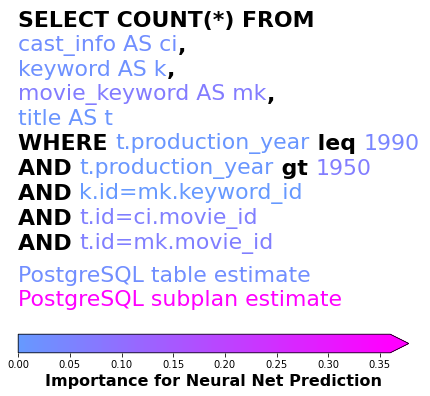

In [86]:
plot_sql_importance(dropoutdata, TABLES)
plt.savefig("Dropout-SQL-Importance.pdf", bbox_inches="tight")

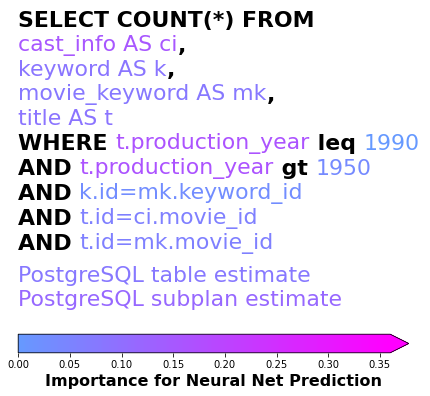

In [87]:
plot_sql_importance(defaultdata, TABLES)
plt.savefig("Default-SQL-Importance.pdf", bbox_inches="tight")